# ***Charge deepxde***

In [1]:
!pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.3/192.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 7.3 MB/s eta 0:00:00


# ***Problem definition***

In [35]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt


m = 2
omega = m * np.pi

geom = dde.geometry.Interval(0, 1)
timedomain = dde.geometry.TimeDomain(0, 1)  # for m =1 (2), the problem is 2 (1) periodic
geomtime = dde.geometry.GeometryXTime(geom, timedomain)


def pde(x, y):

    E, H = y[:, 0:1], y[:, 1:2]
    dE_t = dde.grad.jacobian(y, x, i=0, j=1)
    dH_x = dde.grad.jacobian(y, x, i=1, j=0)
    dH_t = dde.grad.jacobian(y, x, i=1, j=1)
    dE_x = dde.grad.jacobian(y, x, i=0, j=0)

    eq1 = dE_t - dH_x
    eq2 = dH_t - dE_x
    return [eq1, eq2]

# boudary (E=0 在 x=0 和 x=1)
def boundary_E(x, on_boundary):
    return on_boundary and (np.isclose(x[0], 0) or np.isclose(x[0], 1))

bc_E = dde.DirichletBC(geomtime, lambda x: 0, boundary_E, component=0)

# initial (E(x,0) = sin(m*pi*x), H(x,0) = 0)
def initial_E(x):
    return np.sin(m * np.pi * x[:, 0:1])

def initial_H(x):
    return np.zeros_like(x[:, 0:1])

ic_E = dde.IC(geomtime, initial_E, lambda _, on_initial: on_initial, component=0)
ic_H = dde.IC(geomtime, initial_H, lambda _, on_initial: on_initial, component=1)

# Analytical solution
def analy_sol(x):
    E = np.sin(m * np.pi * x[:, 0:1]) * np.cos(omega * x[:, 1:2])
    H = np.cos(m * np.pi * x[:, 0:1]) * np.sin(omega * x[:, 1:2])
    return np.hstack((E, H))


# ***Part1 : Training Data Sampling Parameters for 5 layers and 40 neurons and 15000 epochs***
## Trainning1 : num_domain=600, num_boundary=60 num_initial=60, num_test=300

In [12]:
layer_size = [2] + [40] * 5 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_E, ic_E, ic_H],
    num_domain=300,
    num_boundary=30,
    num_initial=30,
    num_test=300,
    solution = analy_sol
)

# Define and train model
model = dde.Model(data, net)
optimizer = "adam"
model.compile(optimizer, lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=15000, display_every=5000)

Compiling model...
Building feed-forward neural network...
'build' took 0.110066 s

'compile' took 0.722298 s

Training model...

Step      Train loss                                            Test loss                                             Test metric   
0         [1.59e-01, 1.94e-03, 9.93e-02, 5.18e-01, 1.08e-02]    [1.39e-01, 1.28e-03, 9.93e-02, 5.18e-01, 1.08e-02]    [1.11e+00]    
5000      [6.14e-04, 5.71e-04, 2.99e-03, 1.09e-04, 3.53e-05]    [8.27e-04, 7.29e-04, 2.99e-03, 1.09e-04, 3.53e-05]    [2.05e-01]    
10000     [4.50e-04, 6.30e-04, 9.98e-04, 7.39e-05, 7.48e-05]    [5.67e-04, 6.95e-04, 9.98e-04, 7.39e-05, 7.48e-05]    [1.08e-01]    
15000     [3.38e-04, 5.24e-04, 4.82e-04, 4.72e-05, 8.10e-05]    [4.98e-04, 6.16e-04, 4.82e-04, 4.72e-05, 8.10e-05]    [7.29e-02]    

Best model at step 15000:
  train loss: 1.47e-03
  test loss: 1.72e-03
  test metric: [7.29e-02]

'train' took 63.339146 s



# ***Time Evaluation***

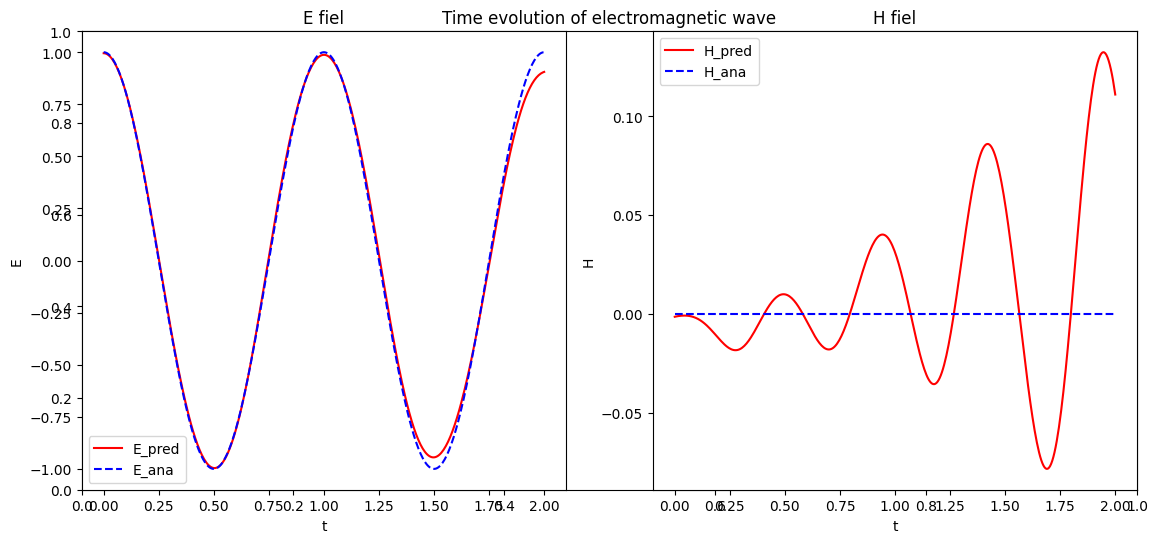

In [13]:
# visualization
T = 2 * np.pi / omega
x_value = 0.25  # fixed point
x2 = np.linspace(0, 2 * T, 400)
x = np.stack((np.full(x2.shape, x_value), x2), axis=-1)
y = model.predict(x)

E_field = y[:, 0:1]
H_field = y[:, 1:2]

E_ana = analy_sol(x)[:, 0:1]
H_ana = analy_sol(x)[:, 1:2]

plt.figure(figsize=(12, 6))
plt.title("Time evolution of electromagnetic wave")
plt.subplot(1, 2, 1)
plt.plot(x2, E_field, 'r', label="E_pred")
plt.plot(x2, E_ana, 'b--', label="E_ana")
plt.xlabel("t")
plt.ylabel("E")
plt.title('E fiel')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x2, H_field, 'r', label="H_pred")
plt.plot(x2, H_ana, 'b--', label="H_ana")
plt.xlabel("t")
plt.ylabel("H")
plt.title('H fiel')
plt.legend()

plt.tight_layout()
plt.show()

## Plort Error

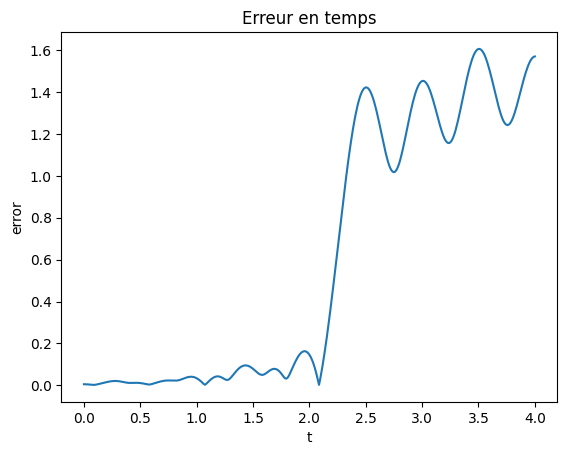

error_max in the trainning domain = [0.16265864]


In [14]:
error = []
x2 = np.linspace(0, 4, 400)
for t in x2: # a chaque l'instan, on calcule l'erreur
  x = np.column_stack([x_value, t])
  y = model.predict(x)
  E_field = y[0, 0:1]
  H_field = y[0, 1:2]

  E_ana = analy_sol(x)[0, 0:1]
  H_ana = analy_sol(x)[0, 1:2]

  error_E = np.abs(E_field - E_ana) # erreur sur champs electriques
  error_H = np.abs(H_field - H_ana) # erreur sur champs magntiques
  error.append(np.sqrt(error_E**2 + error_H**2))
  #print(error)
plt.figure()
plt.plot(x2, error)
plt.xlabel("t")
plt.ylabel("error")
plt.title('Erreur en temps')
plt.show()
print(f"error_max in the trainning domain = {max(error[0:200])}")

# Trainning2 : num_domain=1000, num_boundary=100 num_initial=100, num_test=300

In [15]:
layer_size = [2] + [40] * 5 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_E, ic_E, ic_H],
    num_domain=1000,
    num_boundary=100,
    num_initial=100,
    num_test=300,
    solution = analy_sol
)

# Define and train model
model = dde.Model(data, net)
optimizer = "adam"
model.compile(optimizer, lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=15000, display_every=5000)

Compiling model...
Building feed-forward neural network...
'build' took 0.109402 s

'compile' took 0.821139 s

Training model...

Step      Train loss                                            Test loss                                             Test metric   
0         [1.58e-01, 1.90e-03, 1.04e-01, 4.93e-01, 1.12e-02]    [1.39e-01, 1.28e-03, 1.04e-01, 4.93e-01, 1.12e-02]    [1.09e+00]    
5000      [9.99e-04, 9.29e-04, 5.18e-03, 1.88e-04, 4.91e-05]    [1.38e-03, 1.16e-03, 5.18e-03, 1.88e-04, 4.91e-05]    [2.71e-01]    
10000     [2.05e-04, 2.11e-04, 1.44e-03, 6.45e-05, 4.67e-05]    [2.70e-04, 2.62e-04, 1.44e-03, 6.45e-05, 4.67e-05]    [1.38e-01]    
15000     [1.00e-04, 1.37e-04, 2.72e-04, 1.14e-04, 1.44e-05]    [1.35e-04, 1.48e-04, 2.72e-04, 1.14e-04, 1.44e-05]    [4.35e-02]    

Best model at step 15000:
  train loss: 6.38e-04
  test loss: 6.83e-04
  test metric: [4.35e-02]

'train' took 180.370598 s



# ***Time Evaluation***

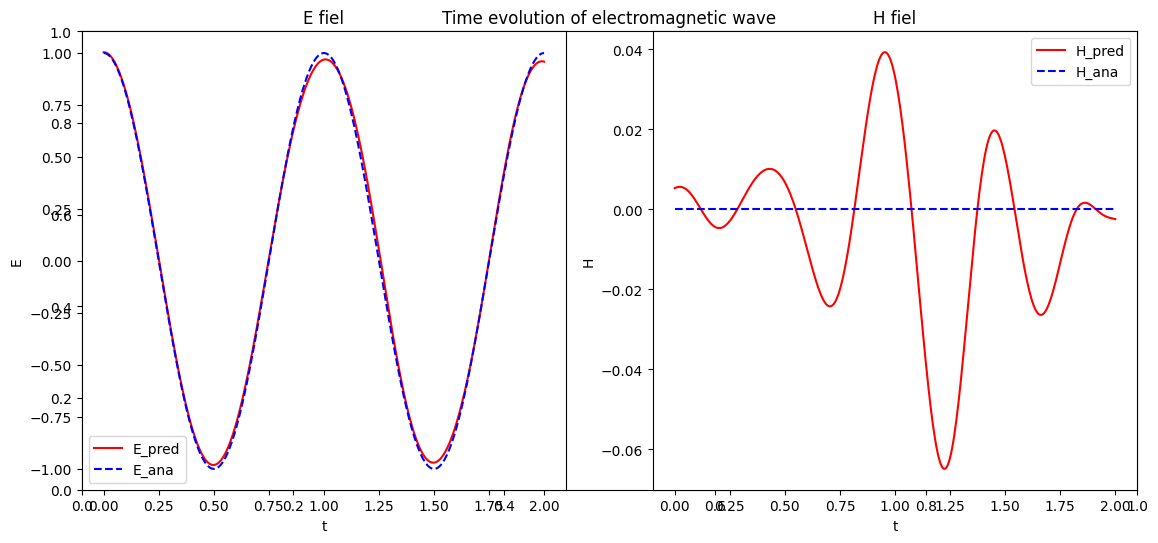

In [16]:
# visualization
T = 2 * np.pi / omega
x_value = 0.25  # fixed point
x2 = np.linspace(0, 2 * T, 400)
x = np.stack((np.full(x2.shape, x_value), x2), axis=-1)
y = model.predict(x)

E_field = y[:, 0:1]
H_field = y[:, 1:2]

E_ana = analy_sol(x)[:, 0:1]
H_ana = analy_sol(x)[:, 1:2]

plt.figure(figsize=(12, 6))
plt.title("Time evolution of electromagnetic wave")
plt.subplot(1, 2, 1)
plt.plot(x2, E_field, 'r', label="E_pred")
plt.plot(x2, E_ana, 'b--', label="E_ana")
plt.xlabel("t")
plt.ylabel("E")
plt.title('E fiel')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x2, H_field, 'r', label="H_pred")
plt.plot(x2, H_ana, 'b--', label="H_ana")
plt.xlabel("t")
plt.ylabel("H")
plt.title('H fiel')
plt.legend()

plt.tight_layout()
plt.show()

## Plot Error

error = []
x2 = np.linspace(0, 4, 400)
for t in x2: # a chaque l'instan, on calcule l'erreur
  x = np.column_stack([x_value, t])
  y = model.predict(x)
  E_field = y[0, 0:1]
  H_field = y[0, 1:2]

  E_ana = analy_sol(x)[0, 0:1]
  H_ana = analy_sol(x)[0, 1:2]

  error_E = np.abs(E_field - E_ana) # erreur sur champs electriques
  error_H = np.abs(H_field - H_ana) # erreur sur champs magntiques
  error.append(np.sqrt(error_E**2 + error_H**2))
  #print(error)
plt.figure()
plt.plot(x2, error)
plt.xlabel("t")
plt.ylabel("error")
plt.title('Erreur en temps')
plt.show()
print(f"error_max in the trainning domain = {max(error[0:200])}")

# Trainning3 : num_domain=1500, num_boundary=160 num_initial=160, num_test=300

In [17]:
layer_size = [2] + [40] * 5 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_E, ic_E, ic_H],
    num_domain=1500,
    num_boundary=160,
    num_initial=160,
    num_test=300,
    solution = analy_sol
)

# Define and train model
model = dde.Model(data, net)
optimizer = "adam"
model.compile(optimizer, lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=15000, display_every=5000)

Compiling model...
Building feed-forward neural network...
'build' took 0.112112 s

'compile' took 1.042215 s

Training model...

Step      Train loss                                            Test loss                                             Test metric   
0         [1.59e-01, 1.94e-03, 1.05e-01, 4.87e-01, 1.13e-02]    [1.39e-01, 1.28e-03, 1.05e-01, 4.87e-01, 1.13e-02]    [1.08e+00]    
5000      [1.29e-03, 1.47e-03, 1.04e-02, 5.74e-04, 4.38e-05]    [1.56e-03, 1.72e-03, 1.04e-02, 5.74e-04, 4.38e-05]    [3.47e-01]    
10000     [5.12e-04, 4.88e-04, 3.11e-03, 1.99e-04, 7.29e-05]    [7.04e-04, 5.41e-04, 3.11e-03, 1.99e-04, 7.29e-05]    [1.62e-01]    
15000     [1.27e-03, 1.94e-03, 1.17e-03, 1.13e-04, 4.73e-04]    [1.42e-03, 2.22e-03, 1.17e-03, 1.13e-04, 4.73e-04]    [9.75e-02]    

Best model at step 10000:
  train loss: 4.38e-03
  test loss: 4.63e-03
  test metric: [1.62e-01]

'train' took 243.578840 s



# ***Time Evaluation***

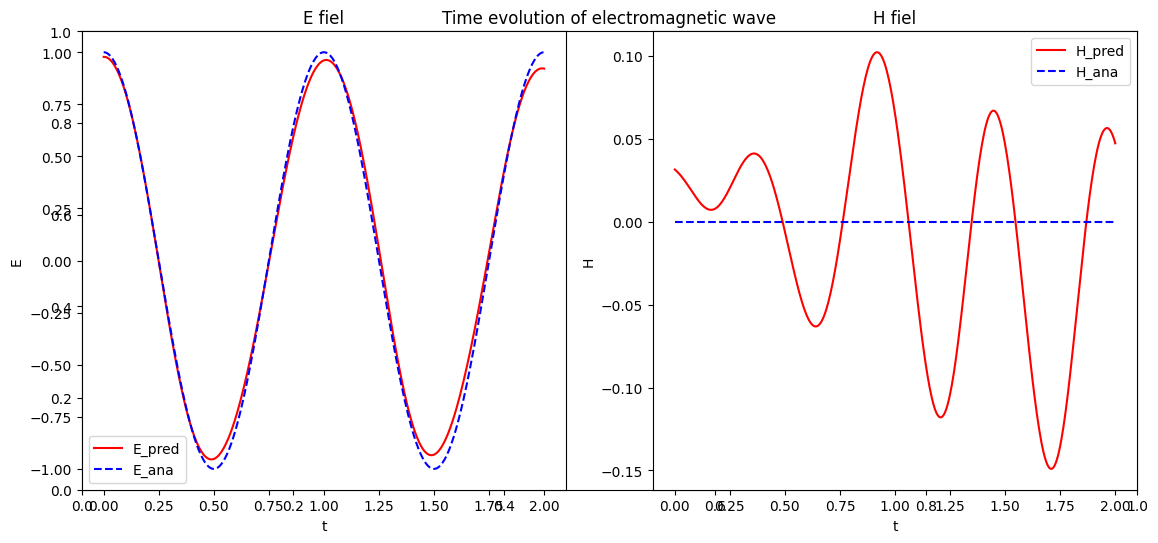

In [18]:
# visualization
T = 2 * np.pi / omega
x_value = 0.25  # fixed point
x2 = np.linspace(0, 2 * T, 400)
x = np.stack((np.full(x2.shape, x_value), x2), axis=-1)
y = model.predict(x)

E_field = y[:, 0:1]
H_field = y[:, 1:2]

E_ana = analy_sol(x)[:, 0:1]
H_ana = analy_sol(x)[:, 1:2]

plt.figure(figsize=(12, 6))
plt.title("Time evolution of electromagnetic wave")
plt.subplot(1, 2, 1)
plt.plot(x2, E_field, 'r', label="E_pred")
plt.plot(x2, E_ana, 'b--', label="E_ana")
plt.xlabel("t")
plt.ylabel("E")
plt.title('E fiel')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x2, H_field, 'r', label="H_pred")
plt.plot(x2, H_ana, 'b--', label="H_ana")
plt.xlabel("t")
plt.ylabel("H")
plt.title('H fiel')
plt.legend()

plt.tight_layout()
plt.show()

## Plot Error

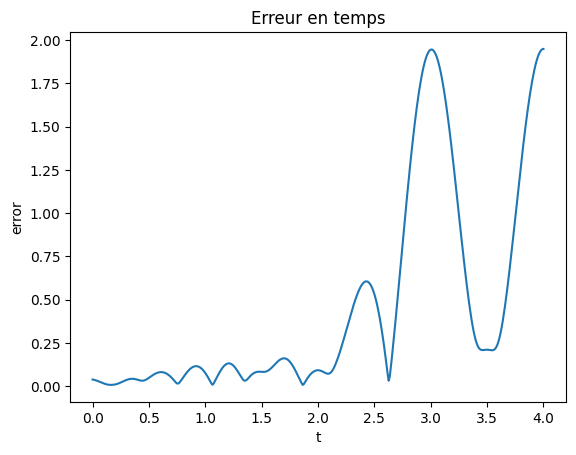

error_max in the trainning domain = [0.16069789]


In [19]:
error = []
x2 = np.linspace(0, 4, 400)
for t in x2: # a chaque l'instan, on calcule l'erreur
  x = np.column_stack([x_value, t])
  y = model.predict(x)
  E_field = y[0, 0:1]
  H_field = y[0, 1:2]

  E_ana = analy_sol(x)[0, 0:1]
  H_ana = analy_sol(x)[0, 1:2]

  error_E = np.abs(E_field - E_ana) # erreur sur champs electriques
  error_H = np.abs(H_field - H_ana) # erreur sur champs magntiques
  error.append(np.sqrt(error_E**2 + error_H**2))
  #print(error)
plt.figure()
plt.plot(x2, error)
plt.xlabel("t")
plt.ylabel("error")
plt.title('Erreur en temps')
plt.show()
print(f"error_max in the trainning domain = {max(error[0:200])}")

# ***Part2 : Epochs Trainning num_domain=1000, num_boundary=100 num_initial=100, num_test=300, 5 layers and 50 neurons***
# Trainning1: epochs = 5000

In [56]:

layer_size = [2] + [50] * 5 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_E, ic_E, ic_H],
    num_domain=1000,
    num_boundary=100,
    num_initial=100,
    num_test=300,
    solution = analy_sol
)

# Define and train model
model = dde.Model(data, net)
optimizer = "adam"
model.compile(optimizer, lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=5000, display_every=2500)


Compiling model...
Building feed-forward neural network...
'build' took 0.120334 s

'compile' took 1.211911 s

Training model...

Step      Train loss                                            Test loss                                             Test metric   
0         [9.11e-03, 3.67e-03, 2.68e-02, 6.40e-01, 1.81e-02]    [9.02e-03, 3.48e-03, 2.68e-02, 6.40e-01, 1.81e-02]    [1.09e+00]    
2500      [2.29e-04, 2.53e-04, 1.29e-03, 9.23e-05, 9.50e-05]    [3.72e-04, 3.25e-04, 1.29e-03, 9.23e-05, 9.50e-05]    [6.64e-02]    
5000      [1.06e-04, 8.01e-05, 3.41e-04, 3.20e-05, 1.66e-05]    [1.76e-04, 1.09e-04, 3.41e-04, 3.20e-05, 1.66e-05]    [3.08e-02]    

Best model at step 5000:
  train loss: 5.76e-04
  test loss: 6.73e-04
  test metric: [3.08e-02]

'train' took 86.326522 s



# ***Time evoluation***

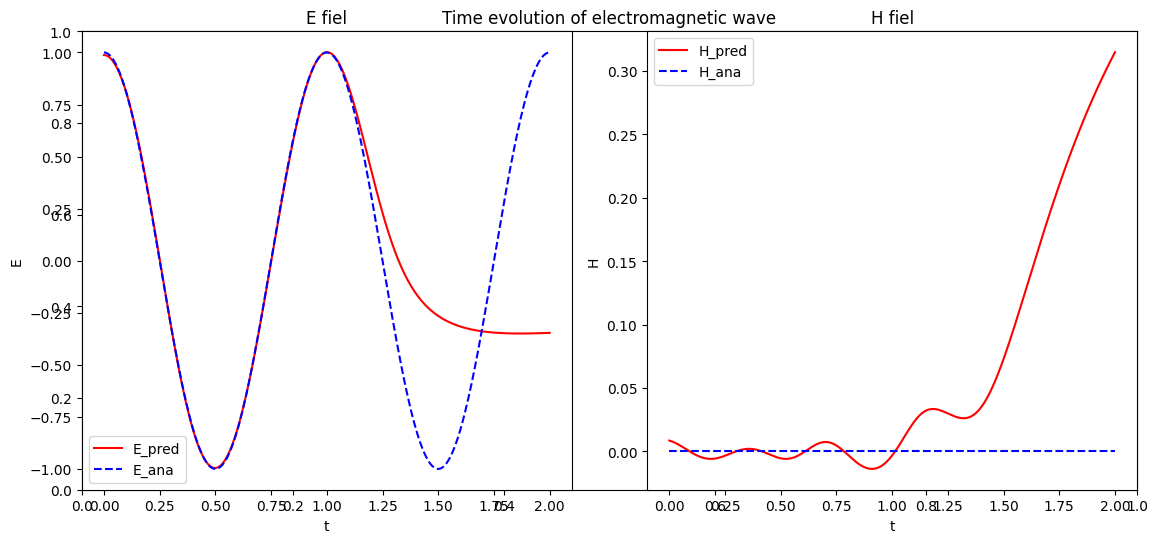

In [57]:
# visualization
T = 2 * np.pi / omega
x_value = 0.25  # fixed point
x2 = np.linspace(0, 2 * T, 400)
x = np.stack((np.full(x2.shape, x_value), x2), axis=-1)
y = model.predict(x)

E_field = y[:, 0:1]
H_field = y[:, 1:2]

E_ana = analy_sol(x)[:, 0:1]
H_ana = analy_sol(x)[:, 1:2]

plt.figure(figsize=(12, 6))
plt.title("Time evolution of electromagnetic wave")
plt.subplot(1, 2, 1)
plt.plot(x2, E_field, 'r', label="E_pred")
plt.plot(x2, E_ana, 'b--', label="E_ana")
plt.xlabel("t")
plt.ylabel("E")
plt.title('E fiel')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x2, H_field, 'r', label="H_pred")
plt.plot(x2, H_ana, 'b--', label="H_ana")
plt.xlabel("t")
plt.ylabel("H")
plt.title('H fiel')
plt.legend()

plt.tight_layout()
plt.show()

## Plot Error

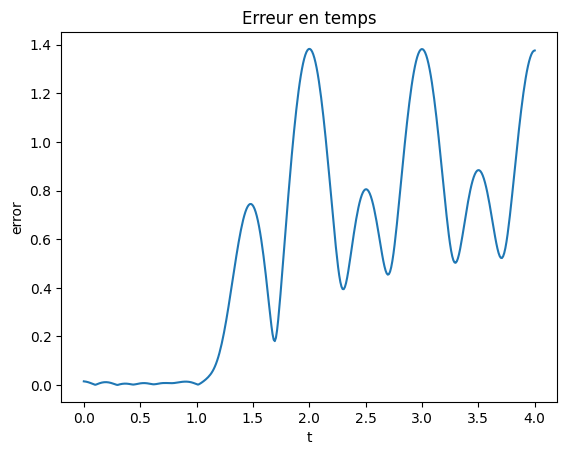

error_max in the trainning domain = [1.38222685]


In [58]:
error = []
x2 = np.linspace(0, 4, 400)
for t in x2: # a chaque l'instan, on calcule l'erreur
  x = np.column_stack([x_value, t])
  y = model.predict(x)
  E_field = y[0, 0:1]
  H_field = y[0, 1:2]

  E_ana = analy_sol(x)[0, 0:1]
  H_ana = analy_sol(x)[0, 1:2]

  error_E = np.abs(E_field - E_ana) # erreur sur champs electriques
  error_H = np.abs(H_field - H_ana) # erreur sur champs magntiques
  error.append(np.sqrt(error_E**2 + error_H**2))
  #print(error)
plt.figure()
plt.plot(x2, error)
plt.xlabel("t")
plt.ylabel("error")
plt.title('Erreur en temps')
plt.show()
print(f"error_max in the trainning domain = {max(error[0:100])}")

# Traninng2: epochs = 10000

In [59]:
layer_size = [2] + [50] * 5 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_E, ic_E, ic_H],
    num_domain=1000,
    num_boundary=100,
    num_initial=100,
    num_test=300,
    solution = analy_sol
)

# Define and train model
model = dde.Model(data, net)
optimizer = "adam"
model.compile(optimizer, lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=10000, display_every=5000)

Compiling model...
Building feed-forward neural network...
'build' took 0.111149 s

'compile' took 1.282682 s

Training model...

Step      Train loss                                            Test loss                                             Test metric   
0         [8.87e-03, 3.80e-03, 3.50e-02, 6.40e-01, 1.81e-02]    [9.02e-03, 3.48e-03, 3.50e-02, 6.40e-01, 1.81e-02]    [1.09e+00]    
5000      [4.81e-05, 6.16e-05, 8.04e-05, 3.92e-05, 6.84e-06]    [7.05e-05, 7.46e-05, 8.04e-05, 3.92e-05, 6.84e-06]    [2.05e-02]    
10000     [4.63e-04, 4.19e-04, 5.04e-05, 7.32e-05, 1.36e-05]    [4.96e-04, 4.61e-04, 5.04e-05, 7.32e-05, 1.36e-05]    [1.44e-02]    

Best model at step 5000:
  train loss: 2.36e-04
  test loss: 2.71e-04
  test metric: [2.05e-02]

'train' took 168.802128 s



# ***Time Evaluation***

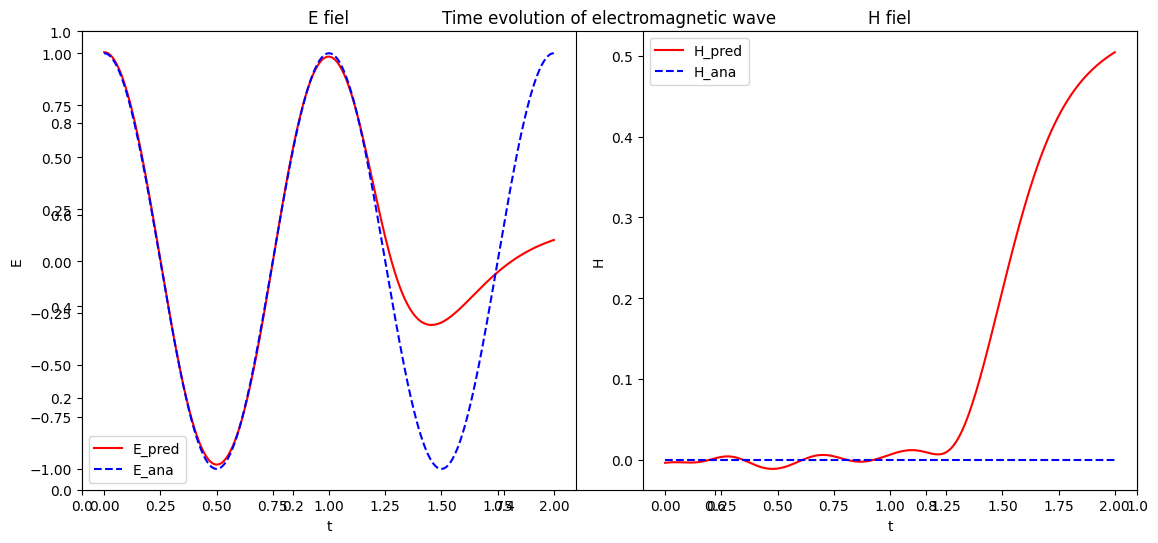

In [60]:
# visualization
T = 2 * np.pi / omega
x_value = 0.25  # fixed point
x2 = np.linspace(0, 2 * T, 400)
x = np.stack((np.full(x2.shape, x_value), x2), axis=-1)
y = model.predict(x)

E_field = y[:, 0:1]
H_field = y[:, 1:2]

E_ana = analy_sol(x)[:, 0:1]
H_ana = analy_sol(x)[:, 1:2]

plt.figure(figsize=(12, 6))
plt.title("Time evolution of electromagnetic wave")
plt.subplot(1, 2, 1)
plt.plot(x2, E_field, 'r', label="E_pred")
plt.plot(x2, E_ana, 'b--', label="E_ana")
plt.xlabel("t")
plt.ylabel("E")
plt.title('E fiel')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x2, H_field, 'r', label="H_pred")
plt.plot(x2, H_ana, 'b--', label="H_ana")
plt.xlabel("t")
plt.ylabel("H")
plt.title('H fiel')
plt.legend()

plt.tight_layout()
plt.show()

## Plot Error

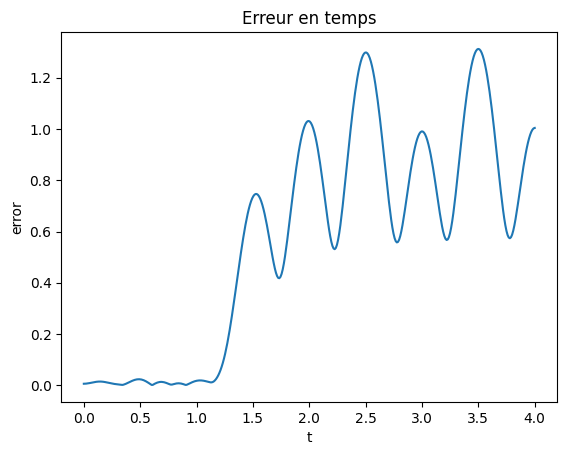

error_max in the trainning domain = [0.02372258]


In [61]:
error = []
x2 = np.linspace(0, 4, 400)
for t in x2: # a chaque l'instan, on calcule l'erreur
  x = np.column_stack([x_value, t])
  y = model.predict(x)
  E_field = y[0, 0:1]
  H_field = y[0, 1:2]

  E_ana = analy_sol(x)[0, 0:1]
  H_ana = analy_sol(x)[0, 1:2]

  error_E = np.abs(E_field - E_ana) # erreur sur champs electriques
  error_H = np.abs(H_field - H_ana) # erreur sur champs magntiques
  error.append(np.sqrt(error_E**2 + error_H**2))
  #print(error)
plt.figure()
plt.plot(x2, error)
plt.xlabel("t")
plt.ylabel("error")
plt.title('Erreur en temps')
plt.show()
print(f"error_max in the trainning domain = {max(error[0:100])}")

# Trainning 3: epochs = 15000

In [ ]:
layer_size = [2] + [50] * 5 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_E, ic_E, ic_H],
    num_domain=1000,
    num_boundary=100,
    num_initial=100,
    num_test=300,
    solution = analy_sol
)

# Define and train model
model = dde.Model(data, net)
optimizer = "adam"
model.compile(optimizer, lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=15000, display_every=5000)

Compiling model...
Building feed-forward neural network...
'build' took 0.151493 s

'compile' took 1.825969 s

Training model...

Step      Train loss                                            Test loss                                             Test metric   
0         [8.97e-03, 3.74e-03, 2.92e-02, 6.40e-01, 1.81e-02]    [9.02e-03, 3.48e-03, 2.92e-02, 6.40e-01, 1.81e-02]    [1.08e+00]    
5000      [9.49e-05, 8.35e-05, 2.01e-05, 1.20e-05, 6.34e-06]    [1.05e-04, 1.12e-04, 2.01e-05, 1.20e-05, 6.34e-06]    [9.19e-03]    


# ***Time Evaluation***

In [ ]:
# visualization
T = 2 * np.pi / omega
x_value = 0.25  # fixed point
x2 = np.linspace(0, 2 * T, 400)
x = np.stack((np.full(x2.shape, x_value), x2), axis=-1)
y = model.predict(x)

E_field = y[:, 0:1]
H_field = y[:, 1:2]

E_ana = analy_sol(x)[:, 0:1]
H_ana = analy_sol(x)[:, 1:2]

plt.figure(figsize=(12, 6))
plt.title("Time evolution of electromagnetic wave")
plt.subplot(1, 2, 1)
plt.plot(x2, E_field, 'r', label="E_pred")
plt.plot(x2, E_ana, 'b--', label="E_ana")
plt.xlabel("t")
plt.ylabel("E")
plt.title('E fiel')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x2, H_field, 'r', label="H_pred")
plt.plot(x2, H_ana, 'b--', label="H_ana")
plt.xlabel("t")
plt.ylabel("H")
plt.title('H fiel')
plt.legend()

plt.tight_layout()
plt.show()

## Plot Error

In [ ]:
error = []
x2 = np.linspace(0, 4, 400)
for t in x2: # a chaque l'instan, on calcule l'erreur
  x = np.column_stack([x_value, t])
  y = model.predict(x)
  E_field = y[0, 0:1]
  H_field = y[0, 1:2]

  E_ana = analy_sol(x)[0, 0:1]
  H_ana = analy_sol(x)[0, 1:2]

  error_E = np.abs(E_field - E_ana) # erreur sur champs electriques
  error_H = np.abs(H_field - H_ana) # erreur sur champs magntiques
  error.append(np.sqrt(error_E**2 + error_H**2))
  #print(error)
plt.figure()
plt.plot(x2, error)
plt.xlabel("t")
plt.ylabel("error")
plt.title('Erreur en temps')
plt.show()
print(f"error_max in the trainning domain = {max(error[0:200])}")

# Trainnig 4: epochs = 20000

In [52]:
layer_size = [2] + [50] * 5 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_E, ic_E, ic_H],
    num_domain=1000,
    num_boundary=100,
    num_initial=100,
    num_test=300,
    solution = analy_sol
)

# Define and train model
model = dde.Model(data, net)
optimizer = "adam"
model.compile(optimizer, lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=20000, display_every=5000)


Compiling model...
Building feed-forward neural network...
'build' took 0.125848 s

'compile' took 1.214581 s

Training model...

Step      Train loss                                            Test loss                                             Test metric   
0         [8.88e-03, 3.78e-03, 3.22e-02, 6.40e-01, 1.81e-02]    [9.02e-03, 3.48e-03, 3.22e-02, 6.40e-01, 1.81e-02]    [1.08e+00]    
5000      [3.01e-04, 2.52e-04, 5.31e-05, 3.80e-05, 2.49e-05]    [3.39e-04, 2.92e-04, 5.31e-05, 3.80e-05, 2.49e-05]    [1.43e-02]    
10000     [2.69e-05, 2.31e-05, 7.75e-06, 4.11e-06, 2.11e-06]    [3.51e-05, 3.23e-05, 7.75e-06, 4.11e-06, 2.11e-06]    [7.52e-03]    
15000     [2.87e-04, 4.26e-04, 8.39e-05, 7.12e-05, 3.95e-05]    [2.96e-04, 4.08e-04, 8.39e-05, 7.12e-05, 3.95e-05]    [1.63e-02]    
20000     [6.65e-06, 8.75e-06, 4.62e-06, 1.94e-06, 1.33e-06]    [1.20e-05, 1.27e-05, 4.62e-06, 1.94e-06, 1.33e-06]    [6.07e-03]    

Best model at step 20000:
  train loss: 2.33e-05
  test loss: 3.26e-05


# ***Time Evaluation***

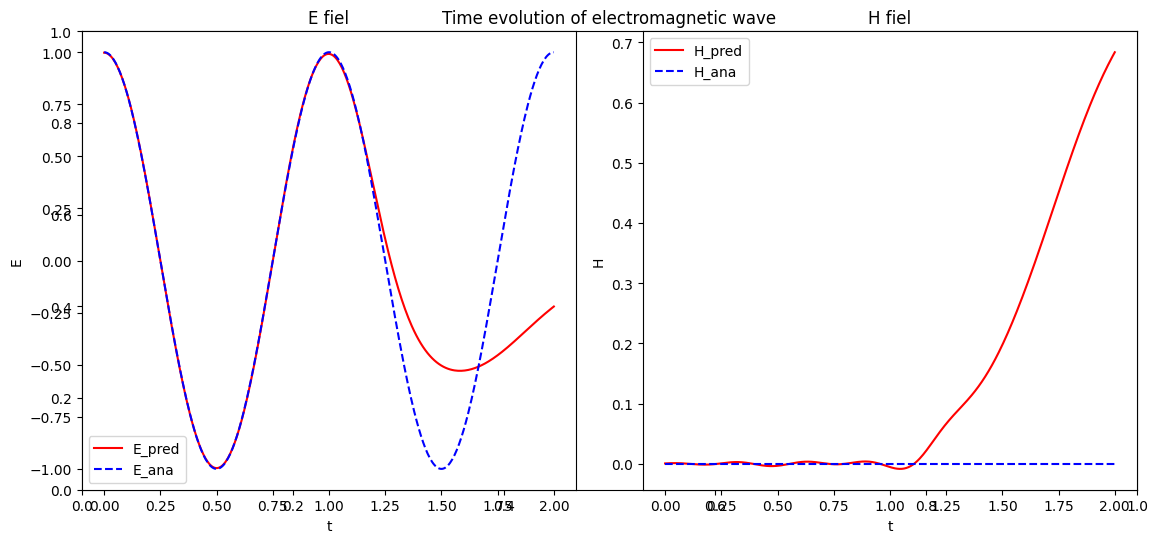

In [53]:
# visualization
T = 2 * np.pi / omega
x_value = 0.25  # fixed point
x2 = np.linspace(0, 2 * T, 400)
x = np.stack((np.full(x2.shape, x_value), x2), axis=-1)
y = model.predict(x)

E_field = y[:, 0:1]
H_field = y[:, 1:2]

E_ana = analy_sol(x)[:, 0:1]
H_ana = analy_sol(x)[:, 1:2]

plt.figure(figsize=(12, 6))
plt.title("Time evolution of electromagnetic wave")
plt.subplot(1, 2, 1)
plt.plot(x2, E_field, 'r', label="E_pred")
plt.plot(x2, E_ana, 'b--', label="E_ana")
plt.xlabel("t")
plt.ylabel("E")
plt.title('E fiel')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x2, H_field, 'r', label="H_pred")
plt.plot(x2, H_ana, 'b--', label="H_ana")
plt.xlabel("t")
plt.ylabel("H")
plt.title('H fiel')
plt.legend()

plt.tight_layout()
plt.show()

## Plot Error

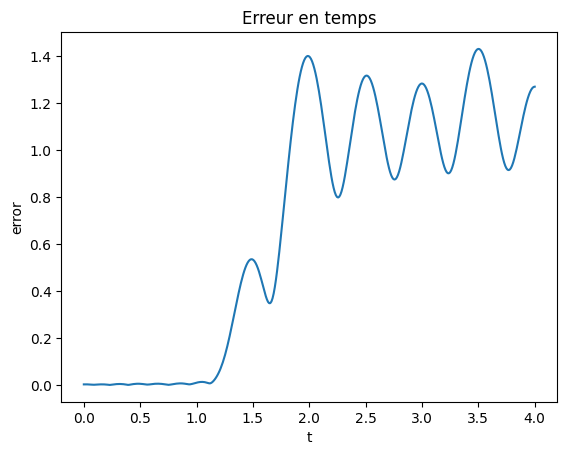

error_max in the trainning domain = [0.00871603]


In [55]:
error = []
x2 = np.linspace(0, 4, 400)
for t in x2: # a chaque l'instan, on calcule l'erreur
  x = np.column_stack([x_value, t])
  y = model.predict(x)
  E_field = y[0, 0:1]
  H_field = y[0, 1:2]

  E_ana = analy_sol(x)[0, 0:1]
  H_ana = analy_sol(x)[0, 1:2]

  error_E = np.abs(E_field - E_ana) # erreur sur champs electriques
  error_H = np.abs(H_field - H_ana) # erreur sur champs magntiques
  error.append(np.sqrt(error_E**2 + error_H**2))
  #print(error)
plt.figure()
plt.plot(x2, error)
plt.xlabel("t")
plt.ylabel("error")
plt.title('Erreur en temps')
plt.show()
print(f"error_max in the trainning domain = {max(error[0:100])}")

error = []
x2 = np.linspace(0, 8, 400)
for t in x2: # a chaque l'instan, on calcule l'erreur
  x = np.column_stack([x_value, t])
  y = model.predict(x)
  E_field = y[0, 0:1]
  H_field = y[0, 1:2]

  E_ana = analy_sol(x)[0, 0:1]
  H_ana = analy_sol(x)[0, 1:2]

  error_E = np.abs(E_field - E_ana) # erreur sur champs electriques
  error_H = np.abs(H_field - H_ana) # erreur sur champs magntiques
  error.append(np.sqrt(error_E**2 + error_H**2))
  #print(error)
plt.figure()
plt.plot(x2, error)
plt.xlabel("t")
plt.ylabel("error")
plt.title('Erreur en temps')
plt.show()
print(f"error_max = {max(error)}")

# Plot result

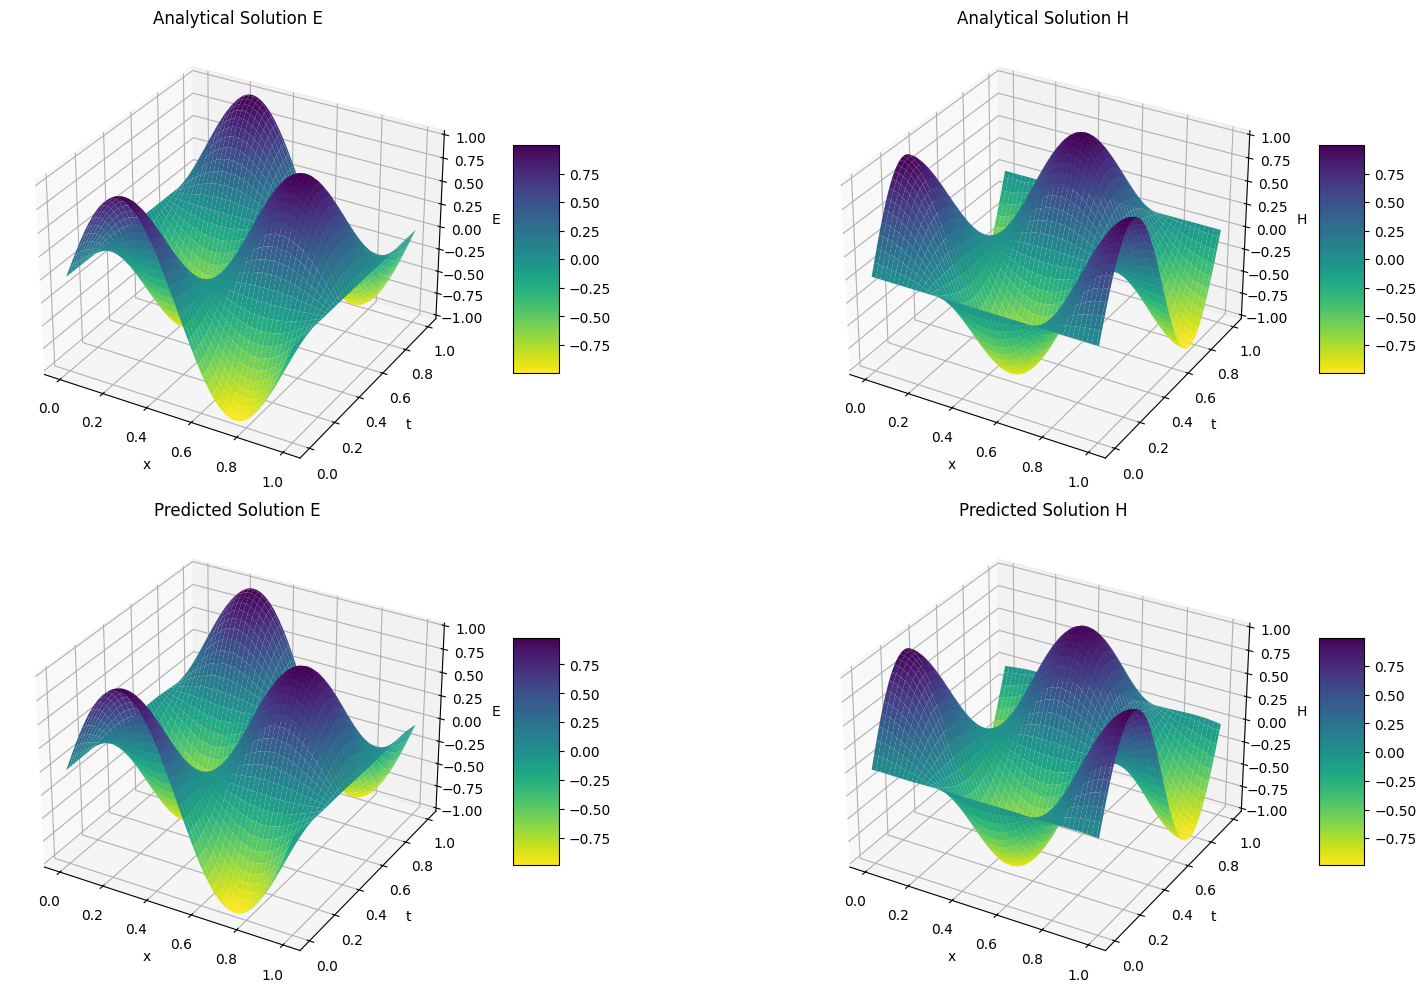

In [40]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x = np.linspace(0, 1, 100)
t = np.linspace(0, 1, 100)
X, T = np.meshgrid(x, t)

E_ex, H_ex = analy_sol(np.hstack((X.reshape(-1, 1), T.reshape(-1, 1)))).T
E_ex = E_ex.reshape(X.shape)
H_ex = H_ex.reshape(X.shape)

E_pred, H_pred = model.predict(np.hstack((X.reshape(-1, 1), T.reshape(-1, 1)))).T
E_pred = E_pred.reshape(X.shape)
H_pred = H_pred.reshape(X.shape)

fig = plt.figure(figsize=(18, 10))

#E
ax1 = fig.add_subplot(221, projection='3d')
E_ex = ax1.plot_surface(X, T, E_ex, cmap='viridis_r', edgecolor='none')
ax1.set_title('Analytical Solution E')
ax1.set_xlabel('x')
ax1.set_ylabel('t')
ax1.set_zlabel('E')
fig.colorbar(E_ex, ax=ax1, shrink=0.5, aspect=5)

# H
ax2 = fig.add_subplot(222, projection='3d')
H_ex = ax2.plot_surface(X, T, H_ex, cmap='viridis_r', edgecolor='none')
ax2.set_title('Analytical Solution H')
ax2.set_xlabel('x')
ax2.set_ylabel('t')
ax2.set_zlabel('H')
fig.colorbar(H_ex, ax=ax2, shrink=0.5, aspect=5)

# prediction of E
ax3 = fig.add_subplot(223, projection='3d')
E_pred = ax3.plot_surface(X, T, E_pred, cmap='viridis_r', edgecolor='none')
ax3.set_title('Predicted Solution E')
ax3.set_xlabel('x')
ax3.set_ylabel('t')
ax3.set_zlabel('E')
fig.colorbar(E_pred, ax=ax3, shrink=0.5, aspect=5)
# prediction of H
ax4 = fig.add_subplot(224, projection='3d')
H_pred = ax4.plot_surface(X, T, H_pred, cmap='viridis_r', edgecolor='none')
ax4.set_title('Predicted Solution H')
ax4.set_xlabel('x')
ax4.set_ylabel('t')
ax4.set_zlabel('H')
fig.colorbar(H_pred, ax=ax4, shrink=0.5, aspect=5)

plt.tight_layout()
plt.show()

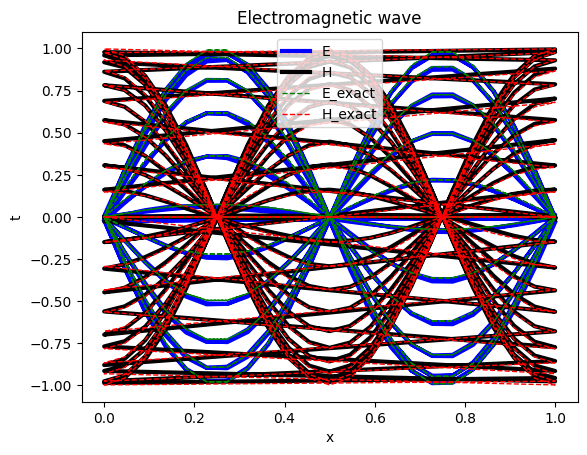

In [41]:
x = geomtime.uniform_points(500)
y = model.predict(x)
fig, ax = plt.subplots()
ax.plot(x[:, 0], y[:, 0], color = 'b', lw = '3', label="E")
ax.plot(x[:, 0], y[:, 1], color = 'black', lw = '3', label="H")
ax.plot(x[:, 0], analy_sol(x)[:, 0], "g--", lw = '1', label="E_exact")
ax.plot(x[:, 0], analy_sol(x)[:, 1], "r--", lw = '1', label="H_exact")
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_title("Electromagnetic wave")
ax.legend()
plt.show()


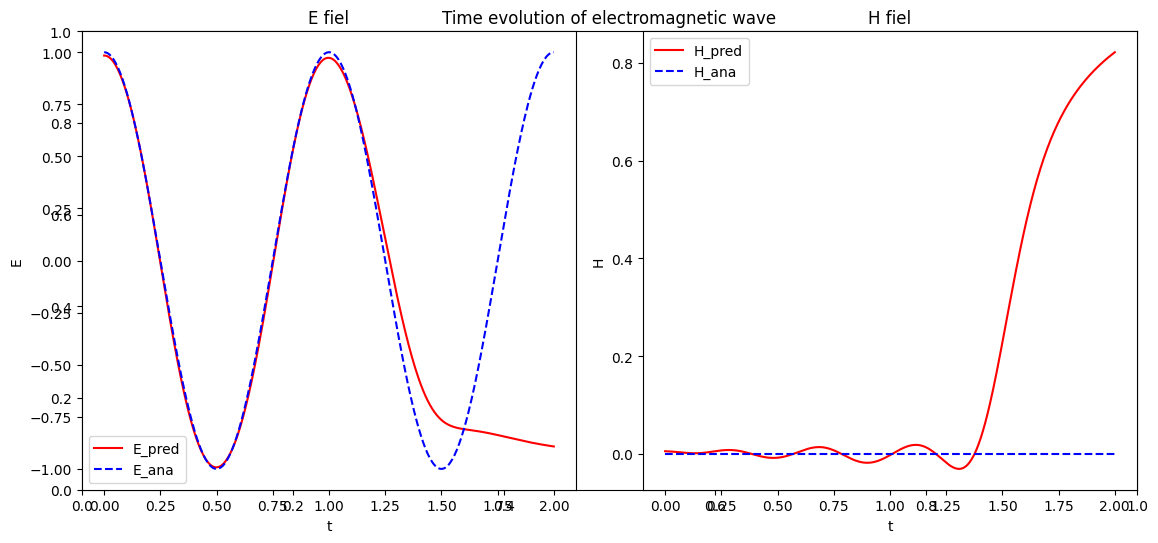

In [42]:
# visualization
T = 2 * np.pi / omega
x_value = 0.25  # fixed point
x2 = np.linspace(0, 2 * T, 400)
x = np.stack((np.full(x2.shape, x_value), x2), axis=-1)
y = model.predict(x)

E_field = y[:, 0:1]
H_field = y[:, 1:2]

E_ana = analy_sol(x)[:, 0:1]
H_ana = analy_sol(x)[:, 1:2]

plt.figure(figsize=(12, 6))
plt.title("Time evolution of electromagnetic wave")
plt.subplot(1, 2, 1)
plt.plot(x2, E_field, 'r', label="E_pred")
plt.plot(x2, E_ana, 'b--', label="E_ana")
plt.xlabel("t")
plt.ylabel("E")
plt.title('E fiel')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x2, H_field, 'r', label="H_pred")
plt.plot(x2, H_ana, 'b--', label="H_ana")
plt.xlabel("t")
plt.ylabel("H")
plt.title('H fiel')
plt.legend()

plt.tight_layout()
plt.show()

# ***Part3 : Neuron NetWork Trainning  num_domain=1000, num_boundary=100 num_initial=100, num_test=300， 15000 epochs***
# Trainning 1: 3 layers and 30 Nerons

In [20]:
layer_size = [2] + [30] * 3 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_E, ic_E, ic_H],
    num_domain=1000,
    num_boundary=100,
    num_initial=100,
    num_test=300,
    solution = analy_sol
)

# Define and train model
model = dde.Model(data, net)
optimizer = "adam"
model.compile(optimizer, lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=15000, display_every=5000)

Compiling model...
Building feed-forward neural network...
'build' took 0.083201 s

'compile' took 0.736328 s

Training model...

Step      Train loss                                            Test loss                                             Test metric   
0         [9.50e-02, 2.15e-01, 4.53e-02, 7.01e-01, 1.58e-02]    [9.88e-02, 2.01e-01, 4.53e-02, 7.01e-01, 1.58e-02]    [1.08e+00]    
5000      [6.17e-04, 5.44e-04, 2.87e-03, 1.71e-04, 7.77e-05]    [7.32e-04, 7.10e-04, 2.87e-03, 1.71e-04, 7.77e-05]    [1.79e-01]    
10000     [1.09e-04, 1.47e-04, 1.24e-03, 2.84e-05, 3.07e-05]    [1.48e-04, 1.76e-04, 1.24e-03, 2.84e-05, 3.07e-05]    [1.07e-01]    
15000     [8.05e-05, 8.90e-05, 5.52e-04, 1.33e-05, 1.66e-05]    [1.18e-04, 1.18e-04, 5.52e-04, 1.33e-05, 1.66e-05]    [6.87e-02]    

Best model at step 15000:
  train loss: 7.51e-04
  test loss: 8.18e-04
  test metric: [6.87e-02]

'train' took 94.283694 s



# ***Time Evaluation***

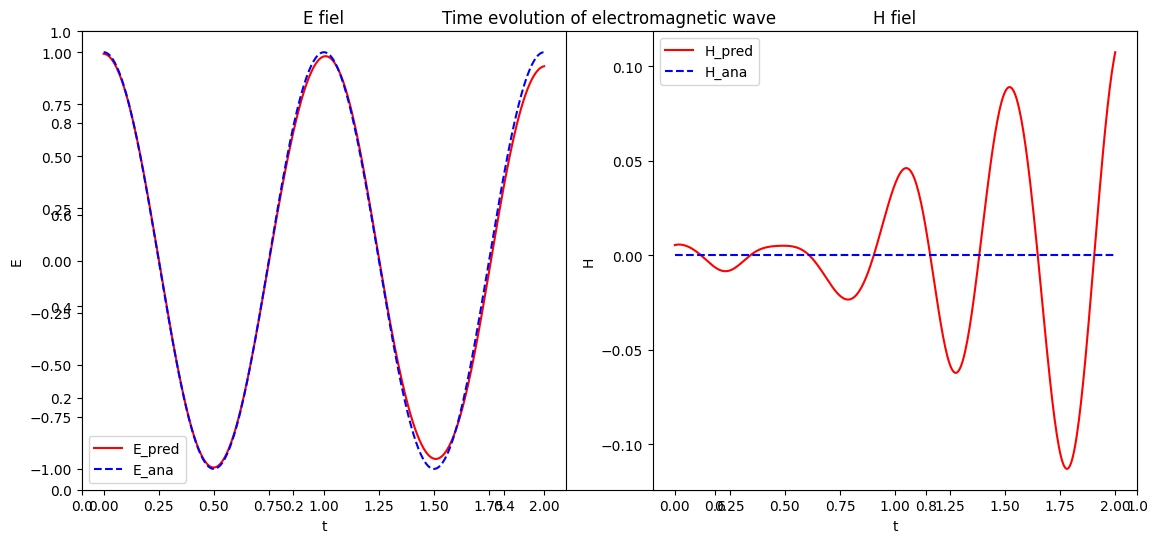

In [21]:
# visualization
T = 2 * np.pi / omega
x_value = 0.25  # fixed point
x2 = np.linspace(0, 2 * T, 400)
x = np.stack((np.full(x2.shape, x_value), x2), axis=-1)
y = model.predict(x)

E_field = y[:, 0:1]
H_field = y[:, 1:2]

E_ana = analy_sol(x)[:, 0:1]
H_ana = analy_sol(x)[:, 1:2]

plt.figure(figsize=(12, 6))
plt.title("Time evolution of electromagnetic wave")
plt.subplot(1, 2, 1)
plt.plot(x2, E_field, 'r', label="E_pred")
plt.plot(x2, E_ana, 'b--', label="E_ana")
plt.xlabel("t")
plt.ylabel("E")
plt.title('E fiel')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x2, H_field, 'r', label="H_pred")
plt.plot(x2, H_ana, 'b--', label="H_ana")
plt.xlabel("t")
plt.ylabel("H")
plt.title('H fiel')
plt.legend()

plt.tight_layout()
plt.show()

## Plot error

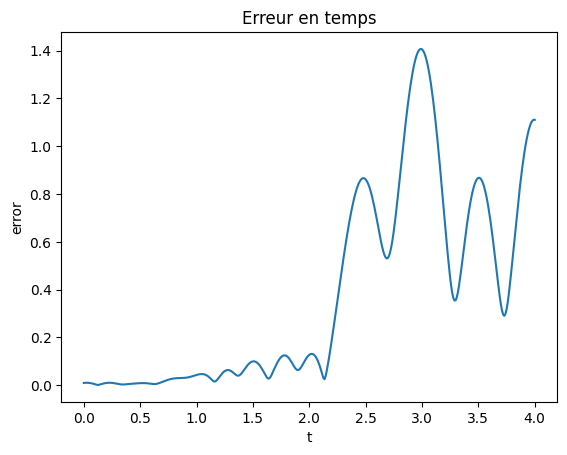

error_max in the trainning domain = [0.12478425]


In [22]:
error = []
x2 = np.linspace(0, 4, 400)
for t in x2: # a chaque l'instan, on calcule l'erreur
  x = np.column_stack([x_value, t])
  y = model.predict(x)
  E_field = y[0, 0:1]
  H_field = y[0, 1:2]

  E_ana = analy_sol(x)[0, 0:1]
  H_ana = analy_sol(x)[0, 1:2]

  error_E = np.abs(E_field - E_ana) # erreur sur champs electriques
  error_H = np.abs(H_field - H_ana) # erreur sur champs magntiques
  error.append(np.sqrt(error_E**2 + error_H**2))
  #print(error)
plt.figure()
plt.plot(x2, error)
plt.xlabel("t")
plt.ylabel("error")
plt.title('Erreur en temps')
plt.show()
print(f"error_max in the trainning domain = {max(error[0:200])}")

# Trainning 2 : 3 layers and 60 Nerons

In [23]:
layer_size = [2] + [60] * 3 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_E, ic_E, ic_H],
    num_domain=1000,
    num_boundary=100,
    num_initial=100,
    num_test=300,
    solution = analy_sol
)

# Define and train model
model = dde.Model(data, net)
optimizer = "adam"
model.compile(optimizer, lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=15000, display_every=5000)

Compiling model...
Building feed-forward neural network...
'build' took 0.104461 s

'compile' took 1.030240 s

Training model...

Step      Train loss                                            Test loss                                             Test metric   
0         [4.58e-02, 1.10e-01, 5.20e-02, 5.29e-01, 7.91e-04]    [4.28e-02, 1.05e-01, 5.20e-02, 5.29e-01, 7.91e-04]    [1.12e+00]    
5000      [4.60e-04, 4.09e-04, 3.02e-03, 1.17e-04, 7.18e-05]    [6.14e-04, 5.24e-04, 3.02e-03, 1.17e-04, 7.18e-05]    [1.85e-01]    
10000     [8.87e-05, 1.67e-04, 4.48e-04, 1.41e-05, 5.29e-05]    [1.10e-04, 1.76e-04, 4.48e-04, 1.41e-05, 5.29e-05]    [6.63e-02]    
15000     [2.27e-04, 1.99e-04, 2.13e-04, 1.06e-05, 2.74e-05]    [2.27e-04, 2.02e-04, 2.13e-04, 1.06e-05, 2.74e-05]    [3.64e-02]    

Best model at step 15000:
  train loss: 6.77e-04
  test loss: 6.80e-04
  test metric: [3.64e-02]

'train' took 176.223180 s



# ***Time Evaluation***

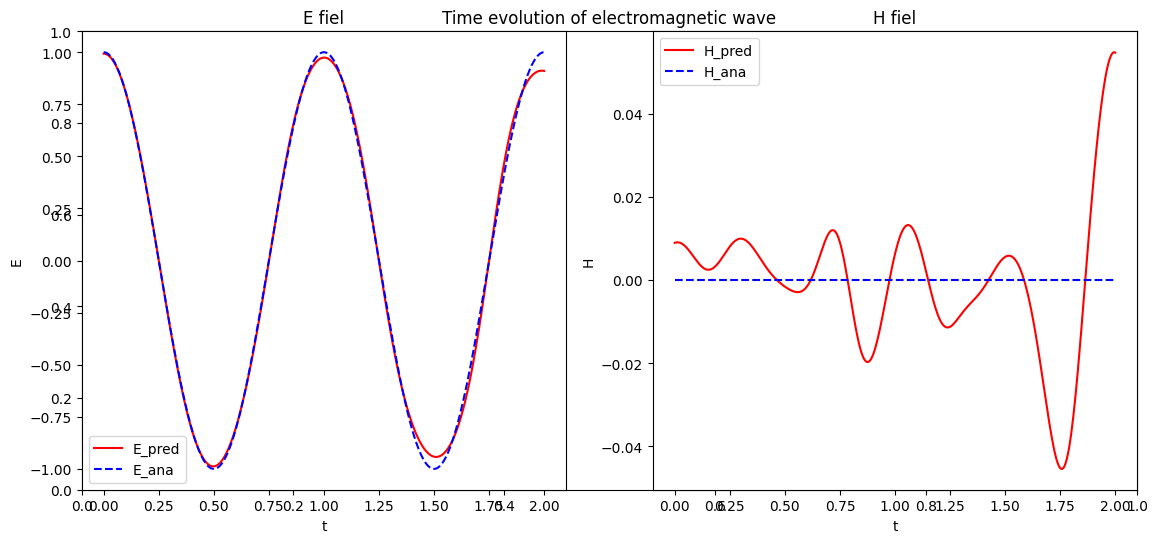

In [24]:
# visualization
T = 2 * np.pi / omega
x_value = 0.25  # fixed point
x2 = np.linspace(0, 2 * T, 400)
x = np.stack((np.full(x2.shape, x_value), x2), axis=-1)
y = model.predict(x)

E_field = y[:, 0:1]
H_field = y[:, 1:2]

E_ana = analy_sol(x)[:, 0:1]
H_ana = analy_sol(x)[:, 1:2]

plt.figure(figsize=(12, 6))
plt.title("Time evolution of electromagnetic wave")
plt.subplot(1, 2, 1)
plt.plot(x2, E_field, 'r', label="E_pred")
plt.plot(x2, E_ana, 'b--', label="E_ana")
plt.xlabel("t")
plt.ylabel("E")
plt.title('E fiel')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x2, H_field, 'r', label="H_pred")
plt.plot(x2, H_ana, 'b--', label="H_ana")
plt.xlabel("t")
plt.ylabel("H")
plt.title('H fiel')
plt.legend()

plt.tight_layout()
plt.show()

## Plot error

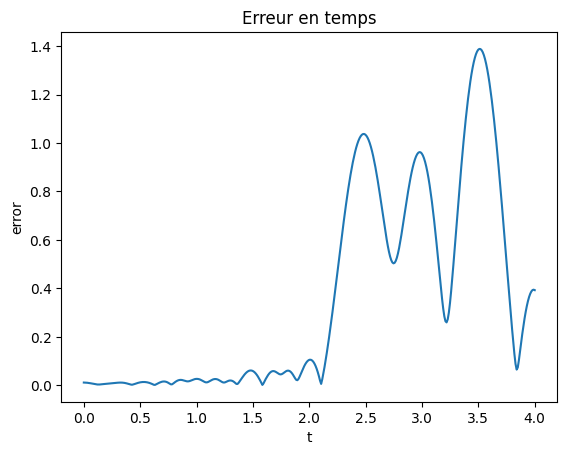

error_max in the trainning domain = [0.10398079]


In [25]:
error = []
x2 = np.linspace(0, 4, 400)
for t in x2: # a chaque l'instan, on calcule l'erreur
  x = np.column_stack([x_value, t])
  y = model.predict(x)
  E_field = y[0, 0:1]
  H_field = y[0, 1:2]

  E_ana = analy_sol(x)[0, 0:1]
  H_ana = analy_sol(x)[0, 1:2]

  error_E = np.abs(E_field - E_ana) # erreur sur champs electriques
  error_H = np.abs(H_field - H_ana) # erreur sur champs magntiques
  error.append(np.sqrt(error_E**2 + error_H**2))
  #print(error)
plt.figure()
plt.plot(x2, error)
plt.xlabel("t")
plt.ylabel("error")
plt.title('Erreur en temps')
plt.show()
print(f"error_max in the trainning domain = {max(error[0:200])}")

# ***Trainning 3 : 4 layers and 30 Nerons***

In [26]:
layer_size = [2] + [30] * 4 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_E, ic_E, ic_H],
    num_domain=1000,
    num_boundary=100,
    num_initial=100,
    num_test=300,
    solution = analy_sol
)

# Define and train model
model = dde.Model(data, net)
optimizer = "adam"
model.compile(optimizer, lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=15000, display_every=5000)

Compiling model...
Building feed-forward neural network...
'build' took 0.093047 s

'compile' took 0.862174 s

Training model...

Step      Train loss                                            Test loss                                             Test metric   
0         [7.73e-04, 8.92e-02, 1.04e-01, 4.39e-01, 5.87e-03]    [8.33e-04, 8.80e-02, 1.04e-01, 4.39e-01, 5.87e-03]    [1.05e+00]    
5000      [6.36e-04, 4.85e-04, 2.39e-03, 1.02e-04, 7.76e-05]    [8.44e-04, 5.51e-04, 2.39e-03, 1.02e-04, 7.76e-05]    [1.54e-01]    
10000     [9.55e-05, 1.35e-04, 3.40e-04, 4.61e-05, 2.09e-05]    [1.10e-04, 1.62e-04, 3.40e-04, 4.61e-05, 2.09e-05]    [4.77e-02]    
15000     [3.09e-05, 4.07e-05, 4.12e-05, 5.60e-06, 3.80e-06]    [3.77e-05, 6.84e-05, 4.12e-05, 5.60e-06, 3.80e-06]    [1.89e-02]    

Best model at step 15000:
  train loss: 1.22e-04
  test loss: 1.57e-04
  test metric: [1.89e-02]

'train' took 127.166764 s



# ***Time Evaluation***

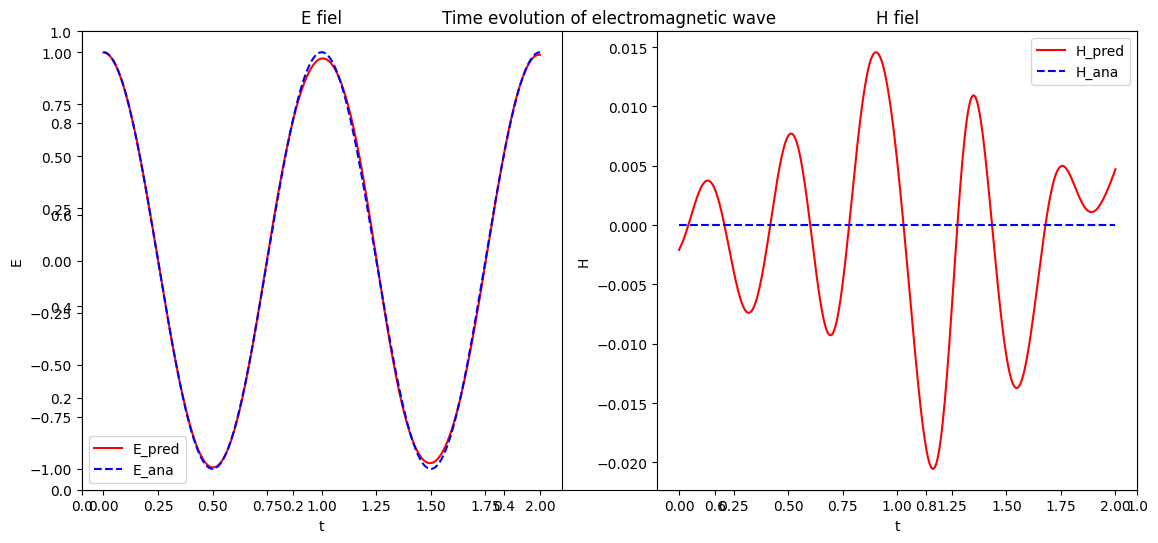

In [27]:
# visualization
T = 2 * np.pi / omega
x_value = 0.25  # fixed point
x2 = np.linspace(0, 2 * T, 400)
x = np.stack((np.full(x2.shape, x_value), x2), axis=-1)
y = model.predict(x)

E_field = y[:, 0:1]
H_field = y[:, 1:2]

E_ana = analy_sol(x)[:, 0:1]
H_ana = analy_sol(x)[:, 1:2]

plt.figure(figsize=(12, 6))
plt.title("Time evolution of electromagnetic wave")
plt.subplot(1, 2, 1)
plt.plot(x2, E_field, 'r', label="E_pred")
plt.plot(x2, E_ana, 'b--', label="E_ana")
plt.xlabel("t")
plt.ylabel("E")
plt.title('E fiel')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x2, H_field, 'r', label="H_pred")
plt.plot(x2, H_ana, 'b--', label="H_ana")
plt.xlabel("t")
plt.ylabel("H")
plt.title('H fiel')
plt.legend()

plt.tight_layout()
plt.show()

## Plot error

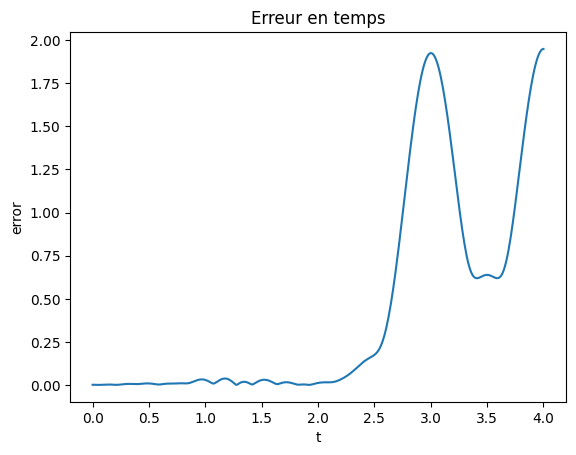

error_max in the trainning domain = [0.03874633]


In [28]:
error = []
x2 = np.linspace(0, 4, 400)
for t in x2: # a chaque l'instan, on calcule l'erreur
  x = np.column_stack([x_value, t])
  y = model.predict(x)
  E_field = y[0, 0:1]
  H_field = y[0, 1:2]

  E_ana = analy_sol(x)[0, 0:1]
  H_ana = analy_sol(x)[0, 1:2]

  error_E = np.abs(E_field - E_ana) # erreur sur champs electriques
  error_H = np.abs(H_field - H_ana) # erreur sur champs magntiques
  error.append(np.sqrt(error_E**2 + error_H**2))
  #print(error)
plt.figure()
plt.plot(x2, error)
plt.xlabel("t")
plt.ylabel("error")
plt.title('Erreur en temps')
plt.show()
print(f"error_max in the trainning domain = {max(error[0:200])}")

# ***Trainning 4 : 4 layers and 60 Nerons***

In [29]:
layer_size = [2] + [60] * 4 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_E, ic_E, ic_H],
    num_domain=1000,
    num_boundary=100,
    num_initial=100,
    num_test=300,
    solution = analy_sol
)

# Define and train model
model = dde.Model(data, net)
optimizer = "adam"
model.compile(optimizer, lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=15000, display_every=5000)

Compiling model...
Building feed-forward neural network...
'build' took 0.098987 s

'compile' took 0.904554 s

Training model...

Step      Train loss                                            Test loss                                             Test metric   
0         [1.90e-01, 1.65e-02, 7.22e-02, 5.32e-01, 1.70e-02]    [1.78e-01, 1.26e-02, 7.22e-02, 5.32e-01, 1.70e-02]    [1.14e+00]    
5000      [7.21e-04, 3.28e-04, 2.30e-03, 3.88e-04, 7.20e-05]    [6.35e-04, 3.65e-04, 2.30e-03, 3.88e-04, 7.20e-05]    [1.38e-01]    
10000     [5.86e-04, 5.27e-04, 3.73e-04, 1.99e-04, 9.52e-05]    [6.33e-04, 5.75e-04, 3.73e-04, 1.99e-04, 9.52e-05]    [4.34e-02]    
15000     [4.21e-05, 2.06e-05, 4.07e-05, 8.99e-06, 3.06e-06]    [4.18e-05, 3.69e-05, 4.07e-05, 8.99e-06, 3.06e-06]    [1.75e-02]    

Best model at step 15000:
  train loss: 1.15e-04
  test loss: 1.31e-04
  test metric: [1.75e-02]

'train' took 230.646350 s



# ***Time Evaluation***

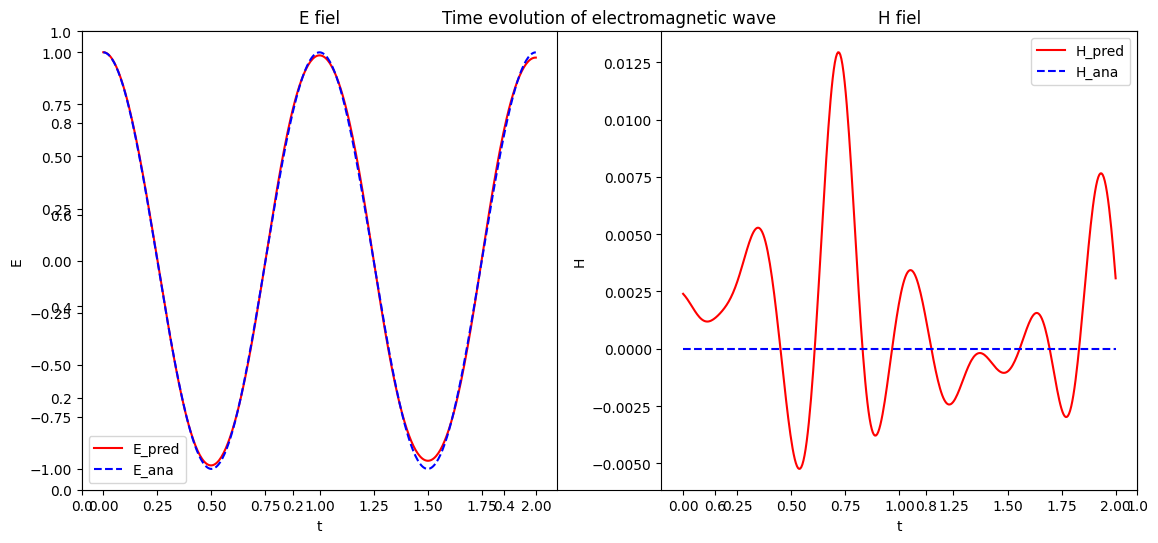

In [30]:
# visualization
T = 2 * np.pi / omega
x_value = 0.25  # fixed point
x2 = np.linspace(0, 2 * T, 400)
x = np.stack((np.full(x2.shape, x_value), x2), axis=-1)
y = model.predict(x)

E_field = y[:, 0:1]
H_field = y[:, 1:2]

E_ana = analy_sol(x)[:, 0:1]
H_ana = analy_sol(x)[:, 1:2]

plt.figure(figsize=(12, 6))
plt.title("Time evolution of electromagnetic wave")
plt.subplot(1, 2, 1)
plt.plot(x2, E_field, 'r', label="E_pred")
plt.plot(x2, E_ana, 'b--', label="E_ana")
plt.xlabel("t")
plt.ylabel("E")
plt.title('E fiel')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x2, H_field, 'r', label="H_pred")
plt.plot(x2, H_ana, 'b--', label="H_ana")
plt.xlabel("t")
plt.ylabel("H")
plt.title('H fiel')
plt.legend()

plt.tight_layout()
plt.show()

## Plot error

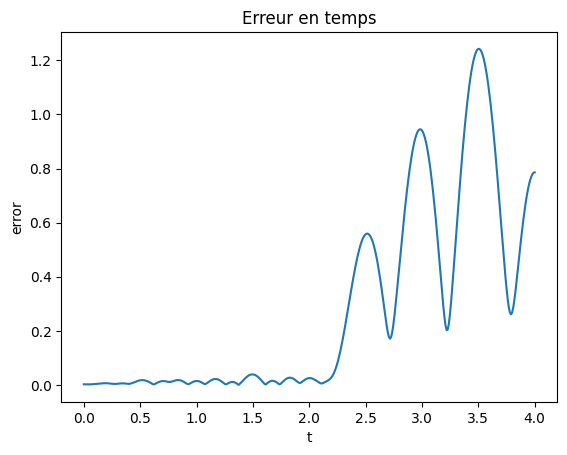

error_max in the trainning domain = [0.03915532]


In [31]:
error = []
x2 = np.linspace(0, 4, 400)
for t in x2: # a chaque l'instan, on calcule l'erreur
  x = np.column_stack([x_value, t])
  y = model.predict(x)
  E_field = y[0, 0:1]
  H_field = y[0, 1:2]

  E_ana = analy_sol(x)[0, 0:1]
  H_ana = analy_sol(x)[0, 1:2]

  error_E = np.abs(E_field - E_ana) # erreur sur champs electriques
  error_H = np.abs(H_field - H_ana) # erreur sur champs magntiques
  error.append(np.sqrt(error_E**2 + error_H**2))
  #print(error)
plt.figure()
plt.plot(x2, error)
plt.xlabel("t")
plt.ylabel("error")
plt.title('Erreur en temps')
plt.show()
print(f"error_max in the trainning domain = {max(error[0:200])}")

# ***Trainning 5 : 5 layers and 30 Nerons***

In [ ]:
layer_size = [2] + [20] * 4 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_E, ic_E, ic_H],
    num_domain=1000,
    num_boundary=100,
    num_initial=100,
    num_test=300,
    solution = analy_sol
)

# Define and train model
model = dde.Model(data, net)
optimizer = "adam"
model.compile(optimizer, lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=6000, display_every=500)

# ***Time Evaluation***

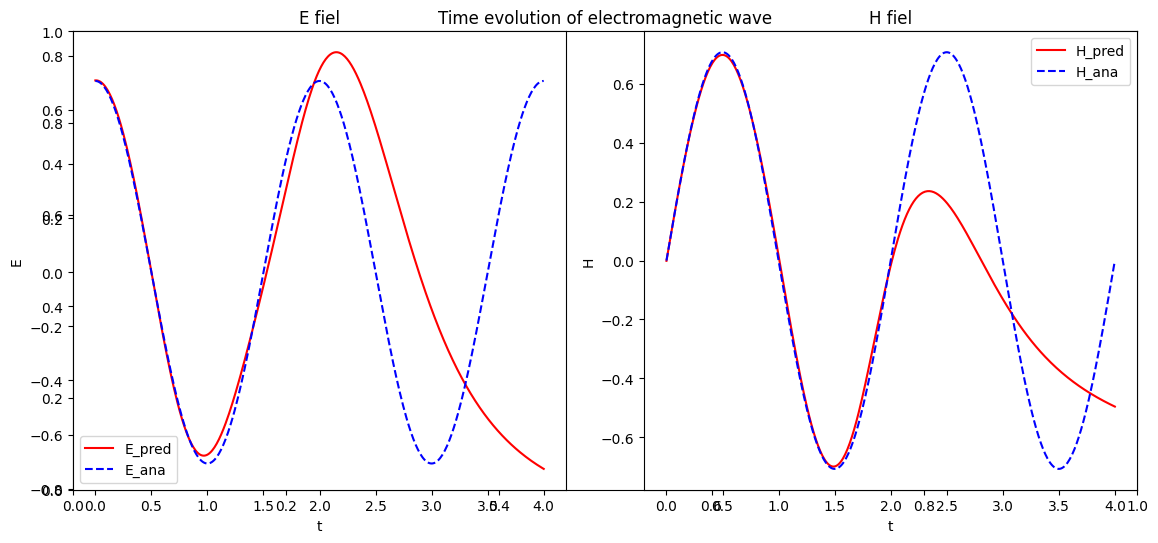

In [ ]:
# visualization
T = 2 * np.pi / omega
x_value = 0.25  # fixed point
x2 = np.linspace(0, 2 * T, 400)
x = np.stack((np.full(x2.shape, x_value), x2), axis=-1)
y = model.predict(x)

E_field = y[:, 0:1]
H_field = y[:, 1:2]

E_ana = analy_sol(x)[:, 0:1]
H_ana = analy_sol(x)[:, 1:2]

plt.figure(figsize=(12, 6))
plt.title("Time evolution of electromagnetic wave")
plt.subplot(1, 2, 1)
plt.plot(x2, E_field, 'r', label="E_pred")
plt.plot(x2, E_ana, 'b--', label="E_ana")
plt.xlabel("t")
plt.ylabel("E")
plt.title('E fiel')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x2, H_field, 'r', label="H_pred")
plt.plot(x2, H_ana, 'b--', label="H_ana")
plt.xlabel("t")
plt.ylabel("H")
plt.title('H fiel')
plt.legend()

plt.tight_layout()
plt.show()

## Plot error

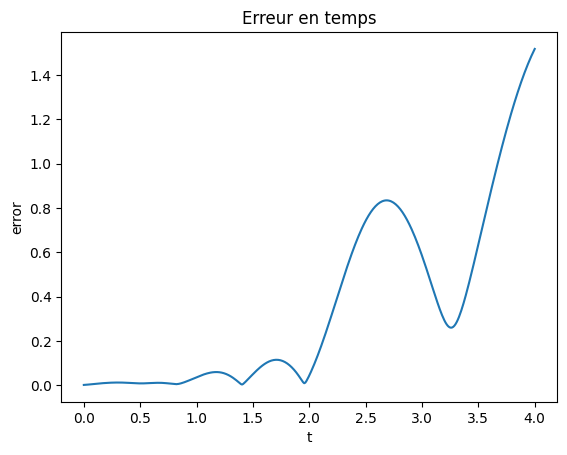

error_max in the trainning domain = [0.11559969]


In [ ]:
error = []
x2 = np.linspace(0, 4, 400)
for t in x2: # a chaque l'instan, on calcule l'erreur
  x = np.column_stack([x_value, t])
  y = model.predict(x)
  E_field = y[0, 0:1]
  H_field = y[0, 1:2]

  E_ana = analy_sol(x)[0, 0:1]
  H_ana = analy_sol(x)[0, 1:2]

  error_E = np.abs(E_field - E_ana) # erreur sur champs electriques
  error_H = np.abs(H_field - H_ana) # erreur sur champs magntiques
  error.append(np.sqrt(error_E**2 + error_H**2))
  #print(error)
plt.figure()
plt.plot(x2, error)
plt.xlabel("t")
plt.ylabel("error")
plt.title('Erreur en temps')
plt.show()
print(f"error_max in the trainning domain = {max(error[0:200])}")

# ***Trainning 6 : 5 layers and 60 Nerons***

In [37]:
layer_size = [2] + [50] * 4 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_E, ic_E, ic_H],
    num_domain=1000,
    num_boundary=100,
    num_initial=100,
    num_test=300,
    solution = analy_sol
)

# Define and train model
model = dde.Model(data, net)
optimizer = "adam"
model.compile(optimizer, lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=6000, display_every=500)

Compiling model...
Building feed-forward neural network...
'build' took 0.139561 s

'compile' took 1.473869 s

Training model...

Step      Train loss                                            Test loss                                             Test metric   
0         [1.95e-01, 4.88e-02, 2.89e-02, 6.34e-01, 4.66e-03]    [1.93e-01, 4.99e-02, 2.89e-02, 6.34e-01, 4.66e-03]    [1.07e+00]    
500       [8.05e-03, 7.82e-03, 3.95e-02, 4.32e-02, 7.07e-03]    [7.39e-03, 7.29e-03, 3.95e-02, 4.32e-02, 7.07e-03]    [6.01e-01]    
1000      [2.16e-03, 1.98e-03, 1.36e-02, 3.18e-03, 9.36e-04]    [2.63e-03, 1.99e-03, 1.36e-02, 3.18e-03, 9.36e-04]    [2.36e-01]    
1500      [9.80e-04, 9.82e-04, 6.18e-03, 1.33e-03, 7.07e-04]    [1.21e-03, 9.57e-04, 6.18e-03, 1.33e-03, 7.07e-04]    [1.53e-01]    
2000      [5.13e-04, 4.22e-04, 2.31e-03, 3.68e-04, 4.20e-04]    [6.61e-04, 4.81e-04, 2.31e-03, 3.68e-04, 4.20e-04]    [9.41e-02]    
2500      [3.32e-04, 2.79e-04, 9.46e-04, 1.34e-04, 1.40e-04]    [4.60e-0

# ***Time Evaluation***

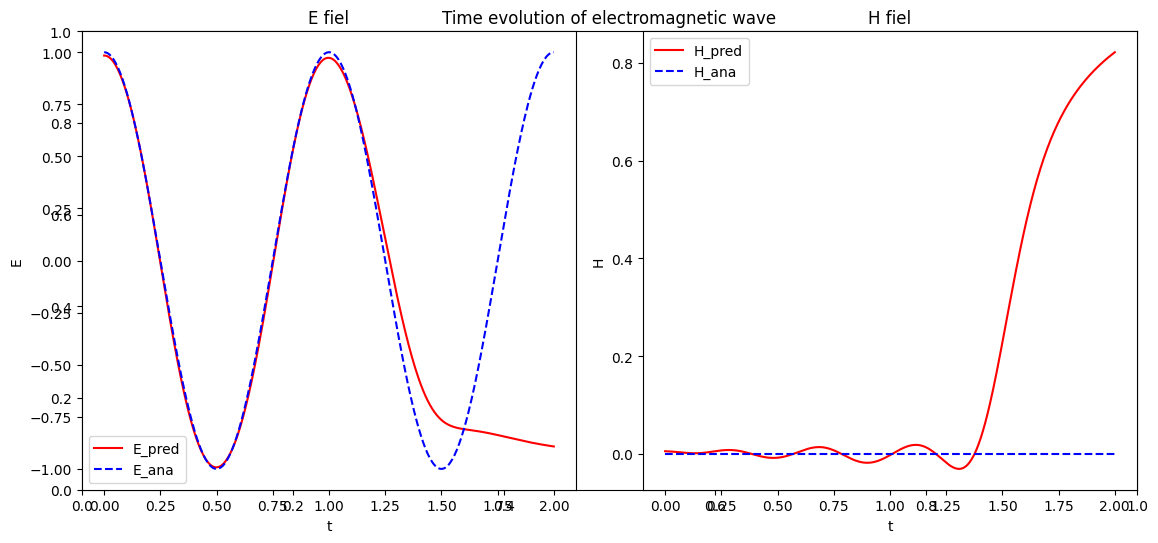

In [38]:
# visualization
T = 2 * np.pi / omega
x_value = 0.25  # fixed point
x2 = np.linspace(0, 2 * T, 400)
x = np.stack((np.full(x2.shape, x_value), x2), axis=-1)
y = model.predict(x)

E_field = y[:, 0:1]
H_field = y[:, 1:2]

E_ana = analy_sol(x)[:, 0:1]
H_ana = analy_sol(x)[:, 1:2]

plt.figure(figsize=(12, 6))
plt.title("Time evolution of electromagnetic wave")
plt.subplot(1, 2, 1)
plt.plot(x2, E_field, 'r', label="E_pred")
plt.plot(x2, E_ana, 'b--', label="E_ana")
plt.xlabel("t")
plt.ylabel("E")
plt.title('E fiel')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x2, H_field, 'r', label="H_pred")
plt.plot(x2, H_ana, 'b--', label="H_ana")
plt.xlabel("t")
plt.ylabel("H")
plt.title('H fiel')
plt.legend()

plt.tight_layout()
plt.show()

## Plot error

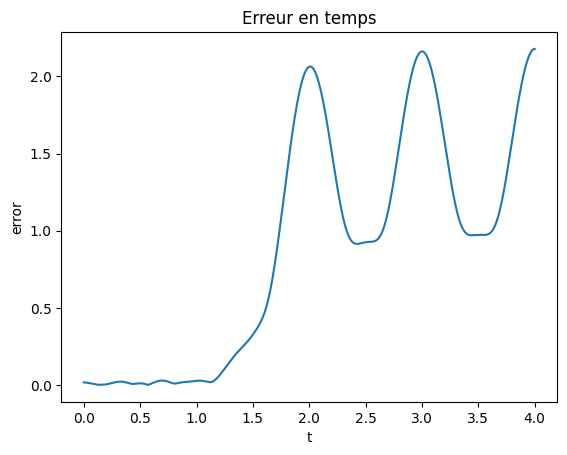

error_max in the trainning domain = [2.06122676]


In [39]:
error = []
x2 = np.linspace(0, 4, 400)
for t in x2: # a chaque l'instan, on calcule l'erreur
  x = np.column_stack([x_value, t])
  y = model.predict(x)
  E_field = y[0, 0:1]
  H_field = y[0, 1:2]

  E_ana = analy_sol(x)[0, 0:1]
  H_ana = analy_sol(x)[0, 1:2]

  error_E = np.abs(E_field - E_ana) # erreur sur champs electriques
  error_H = np.abs(H_field - H_ana) # erreur sur champs magntiques
  error.append(np.sqrt(error_E**2 + error_H**2))
  #print(error)
plt.figure()
plt.plot(x2, error)
plt.xlabel("t")
plt.ylabel("error")
plt.title('Erreur en temps')
plt.show()
print(f"error_max in the trainning domain = {max(error[0:200])}")

# ***Trainning 7 : 6 layers and 40 Nerons***

In [32]:
layer_size = [2] + [80] * 4 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_E, ic_E, ic_H],
    num_domain=1000,
    num_boundary=100,
    num_initial=100,
    num_test=300,
    solution = analy_sol
)

# Define and train model
model = dde.Model(data, net)
optimizer = "adam"
model.compile(optimizer, lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=6000, display_every=500)

Compiling model...
Building feed-forward neural network...
'build' took 0.096771 s

'compile' took 0.908275 s

Training model...

Step      Train loss                                            Test loss                                             Test metric   
0         [2.71e-01, 2.23e-01, 4.82e-02, 4.55e-01, 3.01e-02]    [2.63e-01, 2.20e-01, 4.82e-02, 4.55e-01, 3.01e-02]    [1.06e+00]    
500       [4.53e-03, 4.46e-03, 3.53e-02, 1.69e-02, 4.82e-04]    [4.57e-03, 3.73e-03, 3.53e-02, 1.69e-02, 4.82e-04]    [7.41e-01]    
1000      [3.00e-03, 2.92e-03, 2.59e-02, 2.79e-03, 1.28e-04]    [3.53e-03, 3.06e-03, 2.59e-02, 2.79e-03, 1.28e-04]    [6.52e-01]    
1500      [2.93e-03, 2.77e-03, 2.26e-02, 2.03e-03, 1.23e-04]    [3.55e-03, 2.90e-03, 2.26e-02, 2.03e-03, 1.23e-04]    [6.11e-01]    
2000      [2.65e-03, 2.37e-03, 1.88e-02, 1.63e-03, 1.44e-04]    [3.16e-03, 2.43e-03, 1.88e-02, 1.63e-03, 1.44e-04]    [5.56e-01]    
2500      [1.88e-03, 1.68e-03, 1.27e-02, 8.85e-04, 4.71e-05]    [2.30e-0

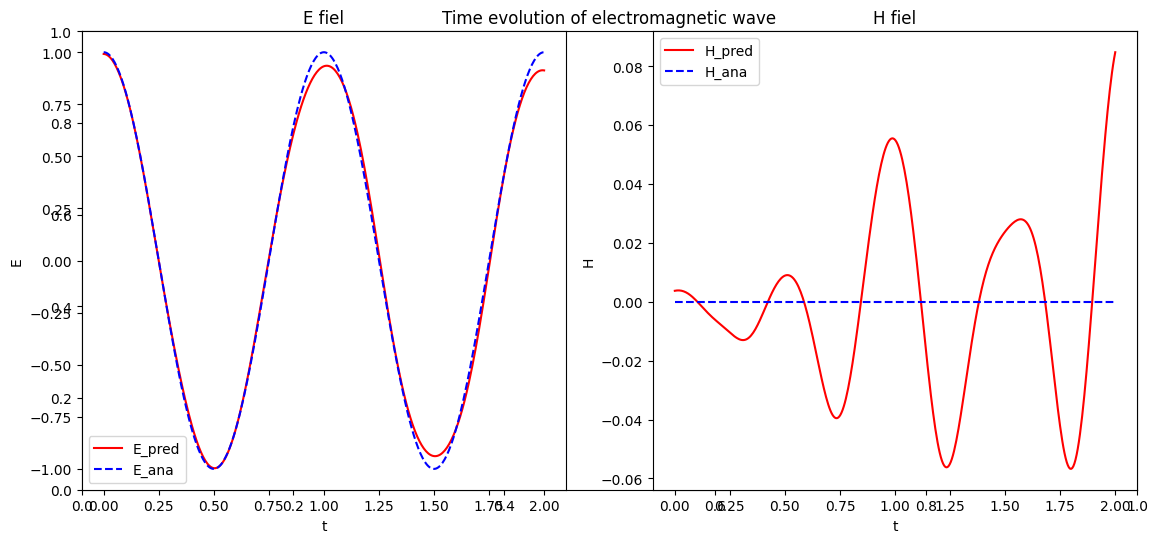

In [33]:
# visualization
T = 2 * np.pi / omega
x_value = 0.25  # fixed point
x2 = np.linspace(0, 2 * T, 400)
x = np.stack((np.full(x2.shape, x_value), x2), axis=-1)
y = model.predict(x)

E_field = y[:, 0:1]
H_field = y[:, 1:2]

E_ana = analy_sol(x)[:, 0:1]
H_ana = analy_sol(x)[:, 1:2]

plt.figure(figsize=(12, 6))
plt.title("Time evolution of electromagnetic wave")
plt.subplot(1, 2, 1)
plt.plot(x2, E_field, 'r', label="E_pred")
plt.plot(x2, E_ana, 'b--', label="E_ana")
plt.xlabel("t")
plt.ylabel("E")
plt.title('E fiel')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x2, H_field, 'r', label="H_pred")
plt.plot(x2, H_ana, 'b--', label="H_ana")
plt.xlabel("t")
plt.ylabel("H")
plt.title('H fiel')
plt.legend()

plt.tight_layout()
plt.show()

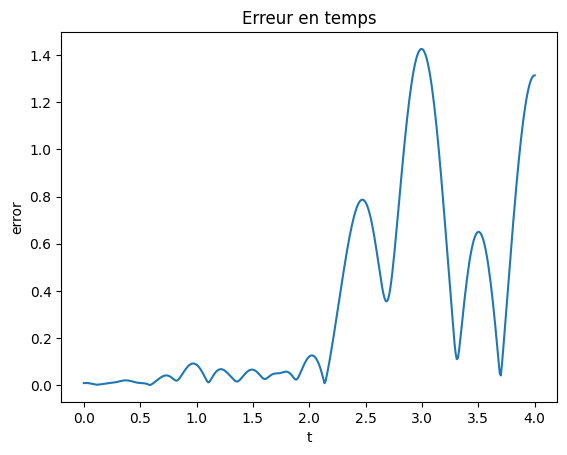

error_max in the trainning domain = [0.11940576]


In [34]:
error = []
x2 = np.linspace(0, 4, 400)
for t in x2: # a chaque l'instan, on calcule l'erreur
  x = np.column_stack([x_value, t])
  y = model.predict(x)
  E_field = y[0, 0:1]
  H_field = y[0, 1:2]

  E_ana = analy_sol(x)[0, 0:1]
  H_ana = analy_sol(x)[0, 1:2]

  error_E = np.abs(E_field - E_ana) # erreur sur champs electriques
  error_H = np.abs(H_field - H_ana) # erreur sur champs magntiques
  error.append(np.sqrt(error_E**2 + error_H**2))
  #print(error)
plt.figure()
plt.plot(x2, error)
plt.xlabel("t")
plt.ylabel("error")
plt.title('Erreur en temps')
plt.show()
print(f"error_max in the trainning domain = {max(error[0:200])}")